# Load libraries and csv file

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
csv = pd.read_csv('Tweets-PH.csv', parse_dates=['year_month'])
csv.head(10)

,year_month,keyword,text,likes,retweets
0,2013-01-01,PE,FAT-FREE ECONOMICS | Philippine economic prosp...,0,0
1,2013-01-01,PE,#happynewyear! Let us help to advance the #Phl...,0,0
2,2013-01-01,PE,FAT-FREE ECONOMICS | Philippine economic prosp...,0,0
3,2013-01-01,PE,@AJEnglish In #Philippines #women &amp; #men #...,0,0
4,2013-01-01,PE,PH economy seen to maintain growth in 2013: M...,0,0
5,2013-01-01,PE,Top Story: PH economy seen to maintain growth ...,0,0
6,2013-01-01,PE,Top CEO's bullish on the Philippine economy in...,0,0
7,2013-01-01,PE,RT @ABSCBNNewsBiz: Philippine economy takes fl...,0,0
8,2013-01-01,PE,"RT ""@RicoHizon: Top CEO's bullish on the Phili...",0,0
9,2013-01-01,PE,Top CEO’s bullish on the Philippine economy in...,0,0


# Prepare data
- aggregate by keyword and year_month
- compute weighted counts (CLRT)

In [44]:
df = (csv
    .groupby('keyword') # PE or PU+
    .resample('M', on='year_month').agg({'text':'count', 'likes':'sum', 'retweets':'sum'})
    .rename(columns={'text':'counts'}))
df = df.assign(**{'CLRT': lambda x: x.counts + x.likes + x.retweets}).reset_index()
df

,keyword,year_month,counts,likes,retweets,CLRT
0,PE,2013-01-31,2632,380,1286,4298
1,PE,2013-02-28,1901,389,966,3256
2,PE,2013-03-31,2104,337,1028,3469
3,PE,2013-04-30,1769,219,579,2567
4,PE,2013-05-31,2726,579,1641,4946
...,...,...,...,...,...,...
235,PU,2022-08-31,74,16795,3298,20167
236,PU,2022-09-30,97,1178,247,1522
237,PU,2022-10-31,93,784,229,1106
238,PU,2022-11-30,69,9343,5260,14672


# Compute ewm averages and standard deviations

In [45]:
vintage_start = pd.to_datetime('2013-01-31')
vintage_end = pd.to_datetime('2022-12-31')

def bollinger_bands(df ,keyword, metric, span=12, factor=2):
    x = df[(df.keyword==keyword)][['year_month',metric]].rename(columns={metric:'metric'}).set_index('year_month')
    x['mu'] = x['metric'].ewm(span=span).mean()
    x['std'] = x['metric'].ewm(span=span).std()
    x['mu_lag'] = x['mu'].shift()
    x['std_lag'] = x['std'].shift()
    x['is_anomaly'] = np.where(np.abs(x['metric'] - x['mu_lag']) > factor * x['std_lag'], 1, 0)
    return x

# Create plot

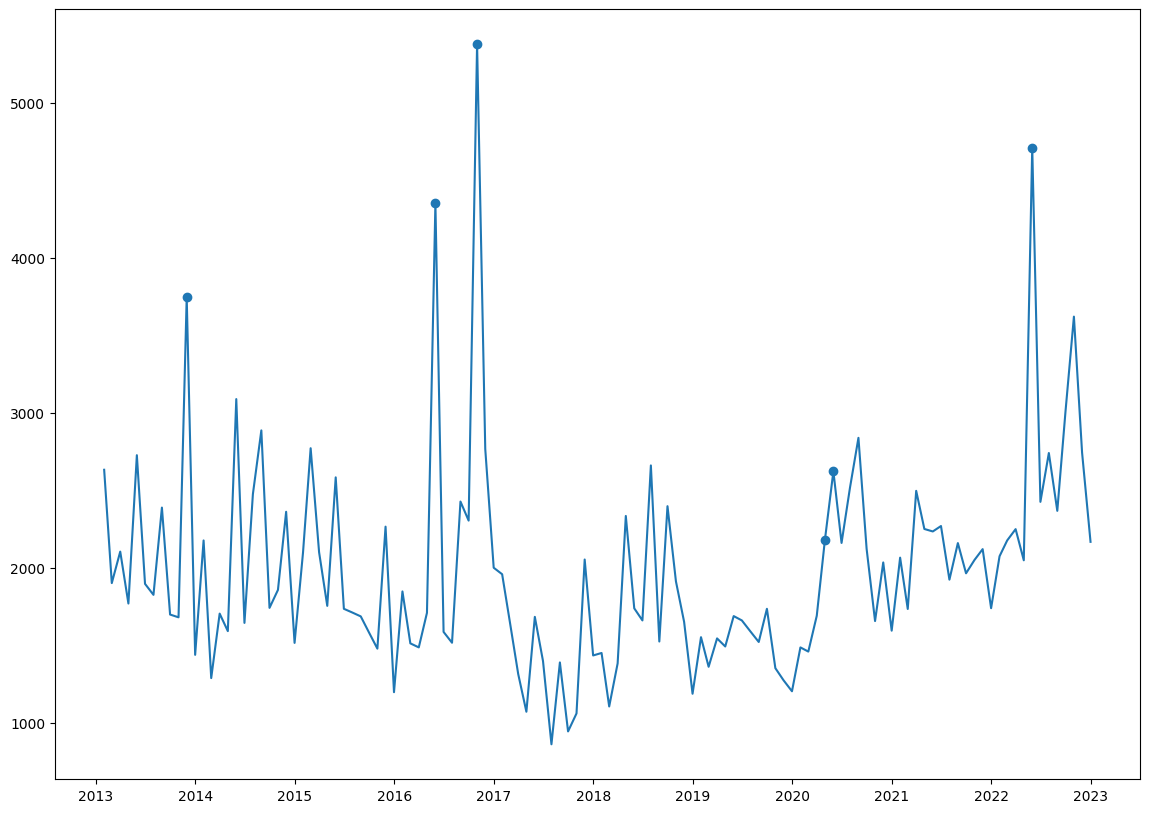

In [46]:
df_var = bollinger_bands(df,'PE', 'counts')
df_var[(df_var.index>=vintage_start) & (df_var.index <=vintage_end)]
fig, ax1 = plt.subplots(figsize=(14, 10))
ax1.plot(df_var.index, (df_var.metric), label='PE Raw Counts')
ax1.scatter(df_var.index[df_var.is_anomaly == 1], (df_var.metric)[df_var.is_anomaly == 1], marker='o')